In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [7]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv')
draft_df = pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_draft_order.csv')


mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_BM_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_BM'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CB_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CB'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CC_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CHRIS'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP'})
mock_draft_df_5=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_SK_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_SK'})

possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_PLAYER_IDS.csv')

In [23]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv',encoding='ISO-8859-1')

file_list =['2020_BM_mockdraft.csv','2020_CB_mockdraft.csv','2020_CC_mockdraft.csv','2020_CP_mockdraft.csv','2020_SK_mockdraft.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    #section not needed for 2021 because it is already all consecutive
    # Check if 'RANK' increases by 1 each time
    #is_consecutive = df['RANK'].diff() == 1
    
    # Use a mask to filter the DataFrame to keep only consecutive ranks
    #df = df[is_consecutive]
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list



#possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv')
#draft_df
#possible_players

mock_draft_dfs[0]

,PLAYER_NAME,PLAYER_ID,md_RANK_BM
0,Alexis Lafreniere,1,1
1,Tim Stutzle,3,2
2,Quinton Byfield,2,3
3,Jamie Drysdale,6,4
4,Cole Perfetti,10,5
...,...,...,...
88,Alexander Pashin,199,89
89,Evan Vierling,127,90
90,Oliver Suni,219,91
91,Thimo Nickl,104,92


In [24]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','md_RANK_BM']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','md_RANK_CB']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','md_RANK_CC']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_CP']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[4][['PLAYER_ID','md_RANK_SK']], how='left', on=['PLAYER_ID'])


df_player_rankings

,PLAYER_ID,md_RANK_BM,md_RANK_CB,md_RANK_CC,md_RANK_CP,md_RANK_SK
0,1,1.0,1.0,1.0,1.0,1.0
1,2,3.0,2.0,2.0,3.0,2.0
2,3,2.0,3.0,3.0,2.0,3.0
3,4,6.0,5.0,7.0,7.0,8.0
4,5,8.0,6.0,5.0,5.0,5.0
...,...,...,...,...,...,...
213,215,NaN,NaN,NaN,NaN,NaN
214,216,NaN,NaN,NaN,NaN,NaN
215,217,NaN,NaN,NaN,NaN,NaN
216,218,23.0,28.0,24.0,28.0,28.0


In [25]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:
        # print(np.exp(sorted_list1[counter-1]))
        # print(np.sum(np.exp(sorted_list1[counter-1:])))
        # print(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 0.8  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [26]:
def constraint_eq(x):
    return sum(x)

In [27]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 40.          38.29184163  38.02563064  34.57007093  34.87956344
  35.38044955  32.08284762  30.97236208  34.05491997  34.46507282
  31.50756131  32.23212411  30.13961792  28.87860016  27.66452291
  28.85802684  27.20270736  29.76182424  28.98993252  22.58488918
 -31.92144428  27.13127232  25.52357897  27.62223365  25.79318615
  24.75680779  27.19339625  26.20996818  26.43433575  26.16573783
  22.94458676  26.013122    20.42529153 -13.35497378  24.70944845
  22.76475344  24.46088684  21.92948924  24.98329773  20.01746248
  25.59943473  21.05503271  10.16918506  23.59306966  18.78746406
  -4.01801809  22.40421403  23.80062069  15.36937672  12.42031252
 -13.29106585  18.23813095  11.67335038  -4.84287992 -13.3344817
  19.19835535 -13.29033825  19.60835432  22.04297244  -0.75315527
 -13.37052842  18.37528713  23.30371548  22.2236414    3.22890133
   7.89286625  21.27735788 -13.32292918  17.96209422 -13.32892052
  24.64392189 -13.33094094  23.12425434  21.86201411  16.09825604
 -13.329076

In [31]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_PLAYER_IDS.csv')
player_ability_parameters_df['ABILITY_PARAMS']=result.x
player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)

,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Alexis Lafreniere,1,40.000000,1
1,Quinton Byfield,2,38.291842,2
2,Tim Stutzle,3,38.025631,3
5,Jamie Drysdale,6,35.380450,4
4,Jake Sanderson,5,34.879563,5
3,Lucas Raymond,4,34.570071,6
9,Cole Perfetti,10,34.465073,7
8,Marco Rossi,9,34.054920,8
11,Anton Lundell,12,32.232124,9
6,Alexander Holtz,7,32.082848,10


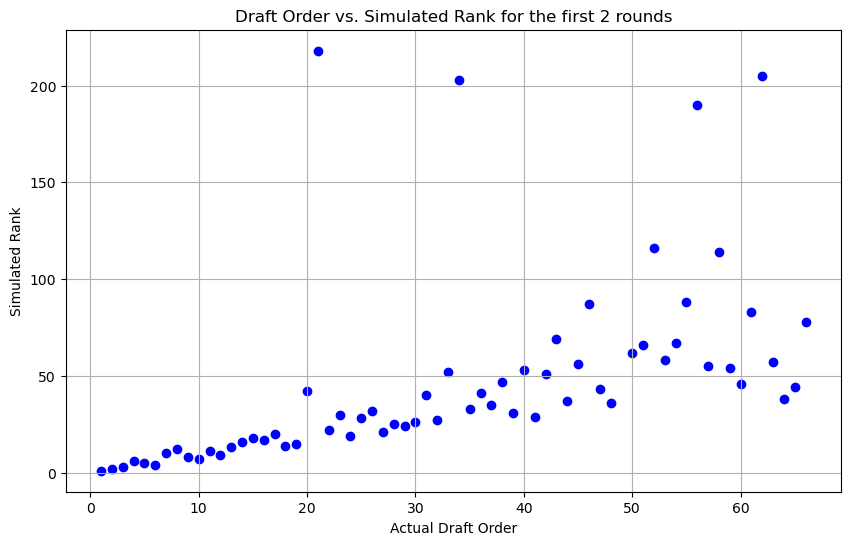

In [32]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()



In [33]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)


# (-40,40 bounds gives 9.59 mae) 



9.59375
